# What

> - The darwin dataset contains handwriting data collected while the participants were performing 25 different tasks.  
> - Contains 452 columns and 175 rows  
> - The last column is the target class: P - Patient and H - Healthy   
> - 89 Patient records and 84 Healthy records 
> - For each task 18 features have been extracted, the column will be identified by the name of the features followed by a numeric identifier 
> representing the task the feature is extracted. 
> - E.g., the column with the header "total_time8" collects the values for the "total time" feature extracted from task #8. 

# Why

> This dataset was created to support the development of better solutions for diagnosing Alzheimer's disease. Since Alzheimer's affects cognitive and motor functions, handwriting analysis can reveal early signs of impairment. By studying handwriting tasks, we can identify patterns that differentiate healthy individuals from patients, potentially enabling earlier and more accurate diagnosis.

# How

> Problem Definition:    
> This is a binary classification problem, but with an important distinction: it’s risk-sensitive. In this case, false negatives are far more costly than false positives, making it critical to prioritize minimizing false negatives, so the model must be optimized to catch as many true positives as possible.

> Chosen Solution:   
> To address this problem, I chose a Decision Tree ensemble using Gradient Boosting. This method was selected because it is particularly effective for handling difficult cases by placing more weight on them during training. Gradient Boosting builds a series of decision trees in an iterative, corrective manner, with each new tree learning from the mistakes of the previous one. This ability to focus on hard-to-classify cases makes it an ideal choice for high-risk scenarios where the goal is to avoid false negatives.

> Additionally, the choice of Gradient Boosting was influenced by the nature of the inputs and outputs:
> - Inputs: The model’s inputs are numerical data, which aligns well with decision trees since they handle continuous numerical features and can naturally split the data at optimal points.
> - Outputs: The outputs are categorical (binary classification), where the goal is to classify the data into one of two classes. Gradient Boosting works well with categorical outputs because it provides robust probabilistic predictions, which can be fine-tuned to emphasize recall and minimize false negatives.

# Imports

In [120]:
import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, VarianceThreshold, RFE, SequentialFeatureSelector
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


# Plot Config

In [121]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('default')
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Constants

In [122]:
# getting a random number for the random state
RANDOM_STATE = np.random.randint(1000)
print(f'Random State: {RANDOM_STATE}')

Random State: 271


# Data Preprocessing

In [123]:
df = pd.read_csv('../data/darwin/DARWIN.csv')
df.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB


>checking for missing values, the dataset has no missing values

In [125]:
pd.set_option('display.max_rows', None)
print(df.isna().sum())

ID                       0
air_time1                0
disp_index1              0
gmrt_in_air1             0
gmrt_on_paper1           0
max_x_extension1         0
max_y_extension1         0
mean_acc_in_air1         0
mean_acc_on_paper1       0
mean_gmrt1               0
mean_jerk_in_air1        0
mean_jerk_on_paper1      0
mean_speed_in_air1       0
mean_speed_on_paper1     0
num_of_pendown1          0
paper_time1              0
pressure_mean1           0
pressure_var1            0
total_time1              0
air_time2                0
disp_index2              0
gmrt_in_air2             0
gmrt_on_paper2           0
max_x_extension2         0
max_y_extension2         0
mean_acc_in_air2         0
mean_acc_on_paper2       0
mean_gmrt2               0
mean_jerk_in_air2        0
mean_jerk_on_paper2      0
mean_speed_in_air2       0
mean_speed_on_paper2     0
num_of_pendown2          0
paper_time2              0
pressure_mean2           0
pressure_var2            0
total_time2              0
a

>using a label encoder to deal with categorical columns   

In [126]:
lb = LabelEncoder()
categorical_columns = df.select_dtypes(include = "object").columns
for col in categorical_columns:
    df[col] = lb.fit_transform(df[col])

> dropping the ID column

In [127]:
df = df.drop('ID', axis=1)

> separating X and y

In [128]:
X = df.drop('class', axis=1)
y = df['class']

# Decision Tree Model

> I choose to use a Decision Tree Model first, to use a starting point to later compare with a few feature selection options   
> I decided to evaluate the model using cross validation since the normal train test split appeared to be overfitting  

In [129]:
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_tree.fit(X, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

scores = cross_val_score(model_tree, X, y, cv=cv, scoring='accuracy')
precision = cross_val_score(model_tree, X, y, cv=cv, scoring='precision')
recall = cross_val_score(model_tree, X, y, cv=cv, scoring='recall')
f1 = cross_val_score(model_tree, X, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.7510893246187366
Precision:  0.771571669071669
Recall:  0.7458333333333333
F1:  0.7501165684447418


> plotting the feature importance for the decision tree

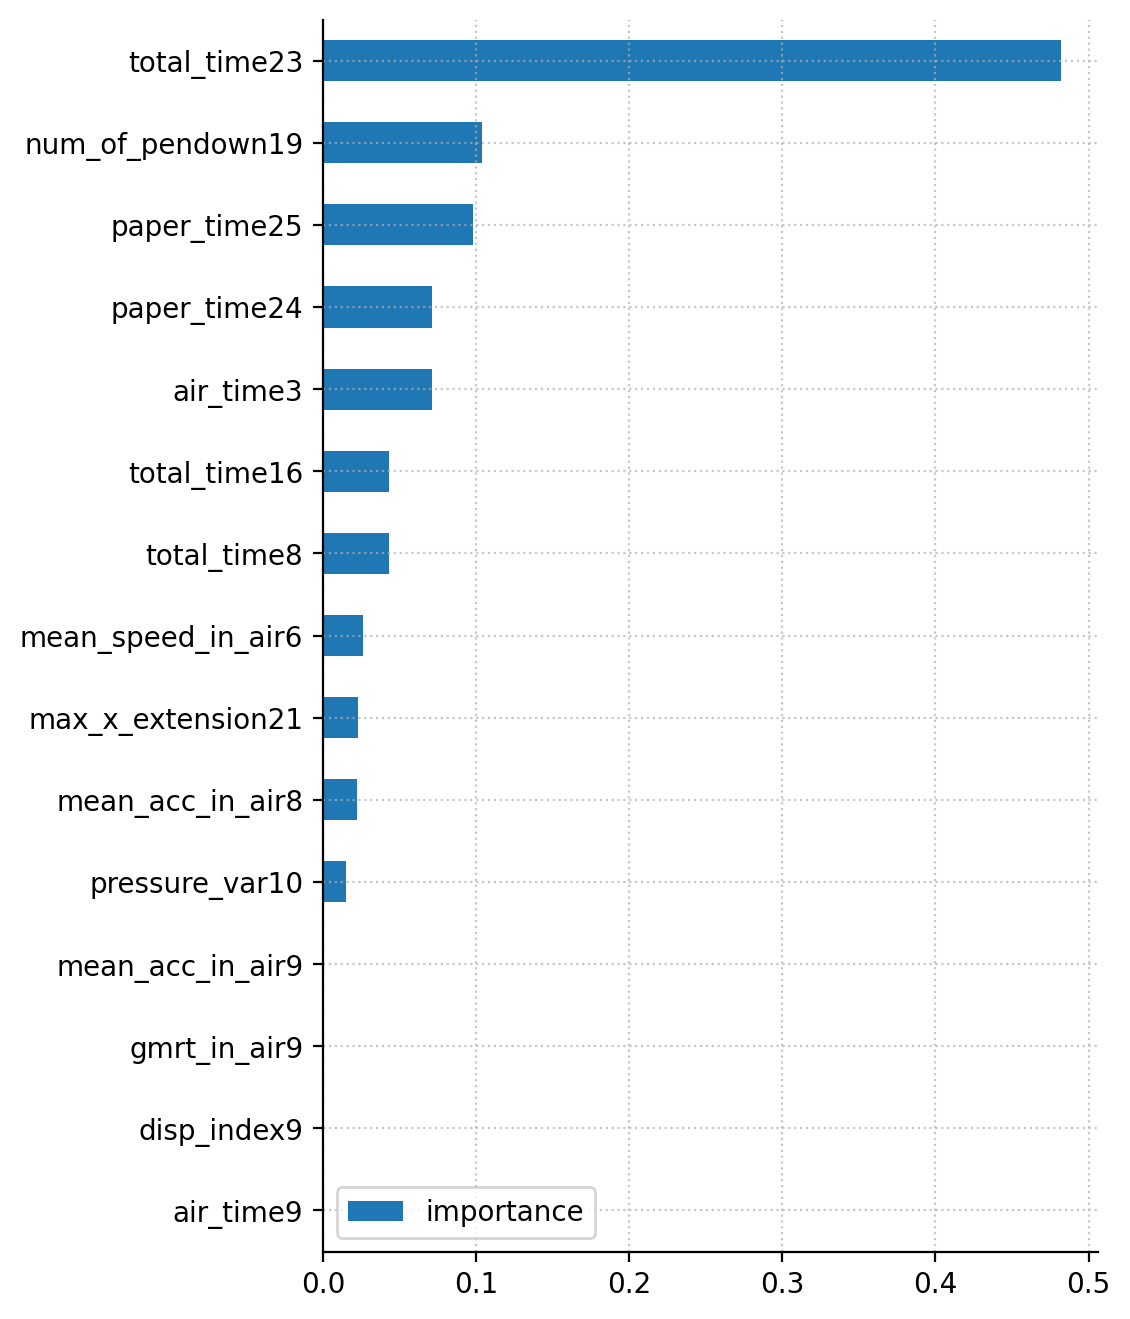

In [130]:
feature_importances = model_tree.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[-15:]
mlp = pd.DataFrame(feature_importances[indices], index=features[indices], columns=['importance'])
mlp.sort_values(by='importance', ascending=False)
mlp.plot(kind='barh', figsize=(5, 8))
plt.show()

# Feature Selection Experiments 

> I'm going to try a few feature selection methods and compare them with the decision tree trained without any feature selction

## Filter Methods

### ANOVA

ANOVA (Analysis of Variance) uses the **F-statistic** to evaluate the correlation between each feature and the target. The features that show the strongest statistical significance will be selected for model training.

In [131]:
k = 10  
selector = SelectKBest(score_func=f_classif, k=k)
X_anova = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print(f"Selected Features: {selected_features.tolist()}")

f_scores = selector.scores_
feature_scores = dict(zip(X.columns, f_scores))
print("Feature Scores:", feature_scores)

Selected Features: ['total_time3', 'gmrt_in_air7', 'mean_gmrt7', 'mean_speed_in_air7', 'paper_time9', 'total_time9', 'air_time16', 'mean_gmrt17', 'disp_index22', 'disp_index23']
Feature Scores: {'air_time1': np.float64(0.807426749193229), 'disp_index1': np.float64(8.920474895954657), 'gmrt_in_air1': np.float64(9.60017432945219), 'gmrt_on_paper1': np.float64(6.887557708143438), 'max_x_extension1': np.float64(0.5861535097625556), 'max_y_extension1': np.float64(0.004176751648643642), 'mean_acc_in_air1': np.float64(3.4302139341998346), 'mean_acc_on_paper1': np.float64(0.6945250622416568), 'mean_gmrt1': np.float64(10.689193674594165), 'mean_jerk_in_air1': np.float64(2.7936077579128673), 'mean_jerk_on_paper1': np.float64(0.11764140087814406), 'mean_speed_in_air1': np.float64(8.611314259823995), 'mean_speed_on_paper1': np.float64(7.236367799844259), 'num_of_pendown1': np.float64(5.505629868959512), 'paper_time1': np.float64(12.63324181359091), 'pressure_mean1': np.float64(17.967848296372726),

> training a tree with the selected features

In [132]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_anova, y)

scores = cross_val_score(tree, X_anova, y, cv=cv, scoring='accuracy')
precision = cross_val_score(tree, X_anova, y, cv=cv, scoring='precision')
recall = cross_val_score(tree, X_anova, y, cv=cv, scoring='recall')
f1 = cross_val_score(tree, X_anova, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))


Accuracy:  0.7564270152505448
Precision:  0.7724567099567099
Recall:  0.7601851851851851
F1:  0.7548389702259671


> getting the best values for k

In [133]:
num_features_list = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

total_features = X.shape[1]

for k in range(1, X.shape[1] + 1, 10):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_anova = selector.fit_transform(X, y)
    
    tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

    accuracy = cross_val_score(tree, X_anova, y, cv=cv, scoring='accuracy')
    precision = cross_val_score(tree, X_anova, y, cv=cv, scoring='precision')
    recall = cross_val_score(tree, X_anova, y, cv=cv, scoring='recall')
    f1 = cross_val_score(tree, X_anova, y, cv=cv, scoring='f1')

    num_features_list.append(k)
    accuracies.append(mean(accuracy))
    precisions.append(mean(precision))
    recalls.append(mean(recall))
    f1_scores.append(mean(f1))

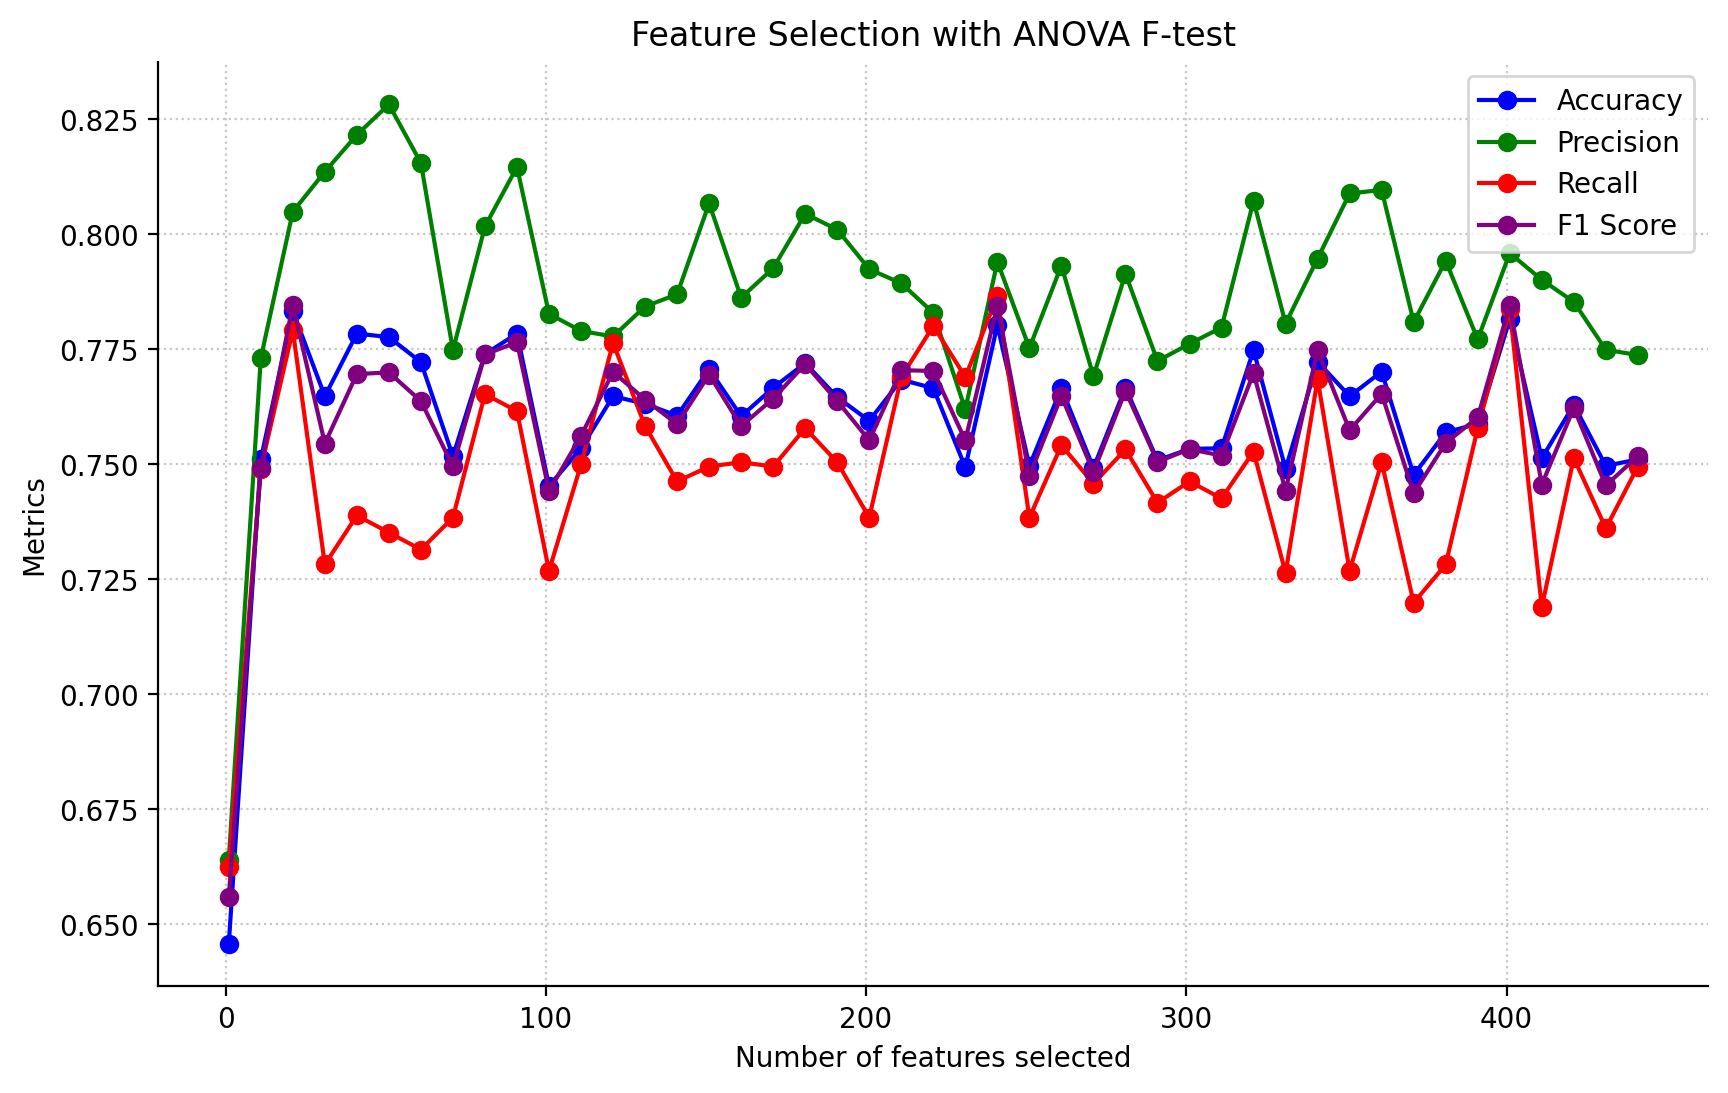

In [134]:
plt.figure(figsize=(10, 6))
plt.title("Feature Selection with ANOVA F-test")
plt.plot(num_features_list, accuracies, label="Accuracy", marker='o', color='blue')
plt.plot(num_features_list, precisions, label="Precision", marker='o', color='green')
plt.plot(num_features_list, recalls, label="Recall", marker='o', color='red')
plt.plot(num_features_list, f1_scores, label="F1 Score", marker='o', color='purple')

plt.xlabel("Number of features selected")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()

> training a tree with the value that maximizes recall

In [135]:
max_recall = max(recalls)
max_recall_index = recalls.index(max_recall)
max_recall_num_features = num_features_list[max_recall_index]
print(f"Max Recall: {max_recall} with {max_recall_num_features} features")

new_model = DecisionTreeClassifier()
rfe = RFE(estimator=new_model, n_features_to_select=max_recall_num_features)
X_transformed = rfe.fit_transform(X, y)

scores = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='accuracy')
precision = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='precision')
recall = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='recall')
f1 = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Max Recall: 0.7865740740740742 with 241 features
Accuracy:  0.7888888888888891
Precision:  0.8136880711880713
Recall:  0.7907407407407409
F1:  0.7900237931429881


## Wrapper Methods

### Sequential Feature Selector

> Sequential Feature Selection (SFS) evaluates subsets of features by adding or removing one feature at a time. It selects the best feature combination based on model performance.


In [136]:
sfs = SequentialFeatureSelector(model_tree, n_features_to_select=10)
X_sfs = sfs.fit_transform(X, y)
selected_features_sfs = X.columns[sfs.get_support()]

print("Features Selected by SFS:")
print(selected_features_sfs.tolist())

Features Selected by SFS:
['disp_index1', 'max_x_extension1', 'num_of_pendown1', 'pressure_mean9', 'total_time9', 'num_of_pendown10', 'total_time13', 'gmrt_on_paper15', 'total_time15', 'mean_jerk_on_paper19']


> training a new tree with the selected features

In [137]:
sfs_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

scores = cross_val_score(sfs_tree, X_sfs, y, cv=cv, scoring='accuracy')
precision = cross_val_score(sfs_tree, X_sfs, y, cv=cv, scoring='precision')
recall = cross_val_score(sfs_tree, X_sfs, y, cv=cv, scoring='recall')
f1 = cross_val_score(sfs_tree, X_sfs, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))


Accuracy:  0.8387799564270153
Precision:  0.851482683982684
Recall:  0.8467592592592593
F1:  0.8436925237931431


### Recursive Feature Elimination

> Recursive Feature Elimination (RFE) recursively removes the least important features based on model performance. It identifies the most influential features by eliminating those that contribute the least, improving model generalization and reducing noise.


In [138]:
rfe = RFE(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE), n_features_to_select=10)

rfe.fit(X, y)

X_rfe = rfe.transform(X)

selected_features_rfe = X.columns[rfe.support_]

print("Features Selected by RFE:")
print(selected_features_rfe.tolist())
print(len(selected_features_rfe))


Features Selected by RFE:
['air_time3', 'num_of_pendown5', 'total_time8', 'num_of_pendown19', 'pressure_mean22', 'mean_jerk_in_air23', 'total_time23', 'paper_time24', 'num_of_pendown25', 'paper_time25']
10


> training a tree with the features selected 

In [139]:
model_tree_rfe = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_tree_rfe.fit(X_rfe, y)

#evaluate
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

scores = cross_val_score(model_tree_rfe, X_rfe, y, cv=cv, scoring='accuracy')
precision = cross_val_score(model_tree_rfe, X_rfe, y, cv=cv, scoring='precision')
recall = cross_val_score(model_tree_rfe, X_rfe, y, cv=cv, scoring='recall')
f1 = cross_val_score(model_tree_rfe, X_rfe, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.9043572984749456
Precision:  0.921410533910534
Recall:  0.8962962962962963
F1:  0.9046706226350189


> getting the metrics a tree trained with rfe selected features with the number of features from 1 to 450 with a step of 10

In [140]:
base_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

num_features_list = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

total_features = X.shape[1]

for num_features in range(1, total_features + 1, 10):
    rfe = RFE(estimator=base_model, n_features_to_select=num_features)
    X_transformed = rfe.fit_transform(X, y)

    accuracy = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='accuracy')
    precision = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='precision')
    recall = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='recall')
    f1 = cross_val_score(base_model, X_transformed, y, cv=cv, scoring='f1')

    num_features_list.append(num_features)
    accuracies.append(mean(accuracy))
    precisions.append(mean(precision))
    recalls.append(mean(recall))
    f1_scores.append(mean(f1))

> plotting the features selected vs the metrics results

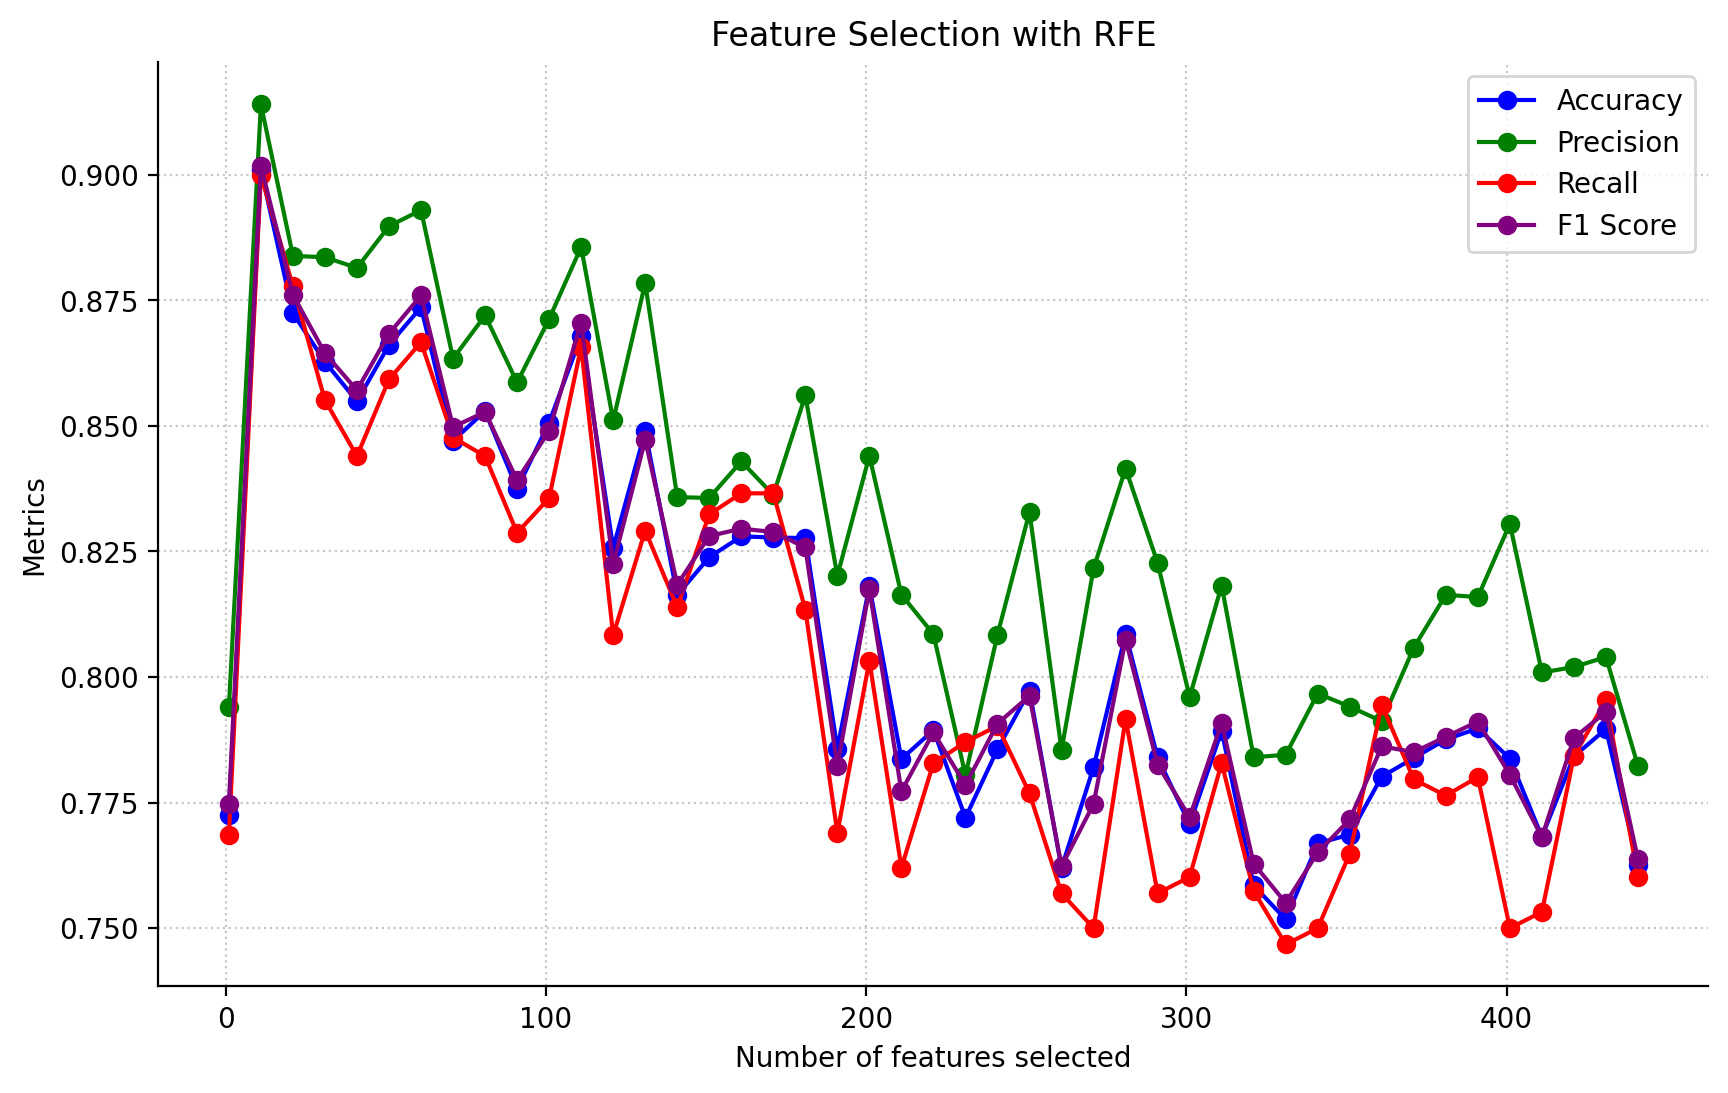

In [141]:
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, accuracies, label="Accuracy", marker='o', color='blue')
plt.plot(num_features_list, precisions, label="Precision", marker='o', color='green')
plt.plot(num_features_list, recalls, label="Recall", marker='o', color='red')
plt.plot(num_features_list, f1_scores, label="F1 Score", marker='o', color='purple')
plt.title("Feature Selection with RFE")
plt.xlabel("Number of features selected")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()


#### Decision Tree Combined With RFE Maximizing Recall

> getting the number of features that maximizes recall

In [142]:
max_recall = max(recalls)
max_recall_index = recalls.index(max_recall)
max_recall_num_features = num_features_list[max_recall_index]
print(f"Max Recall: {max_recall} with {max_recall_num_features} features")

Max Recall: 0.9 with 11 features


> training a new tree using the rfe for feature selection with the number of fratures that maximazes reccall

In [143]:
new_model = DecisionTreeClassifier()
rfe = RFE(estimator=new_model, n_features_to_select=max_recall_num_features)
X_transformed = rfe.fit_transform(X, y)

scores = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='accuracy')
precision = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='precision')
recall = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='recall')
f1 = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))



Accuracy:  0.9045751633986928
Precision:  0.9157455507455509
Recall:  0.8962962962962965
F1:  0.8936952675807165


#### Decision Tree Using RFECV 

In [144]:
base_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
rfecv = RFECV(
    estimator=base_model,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 444


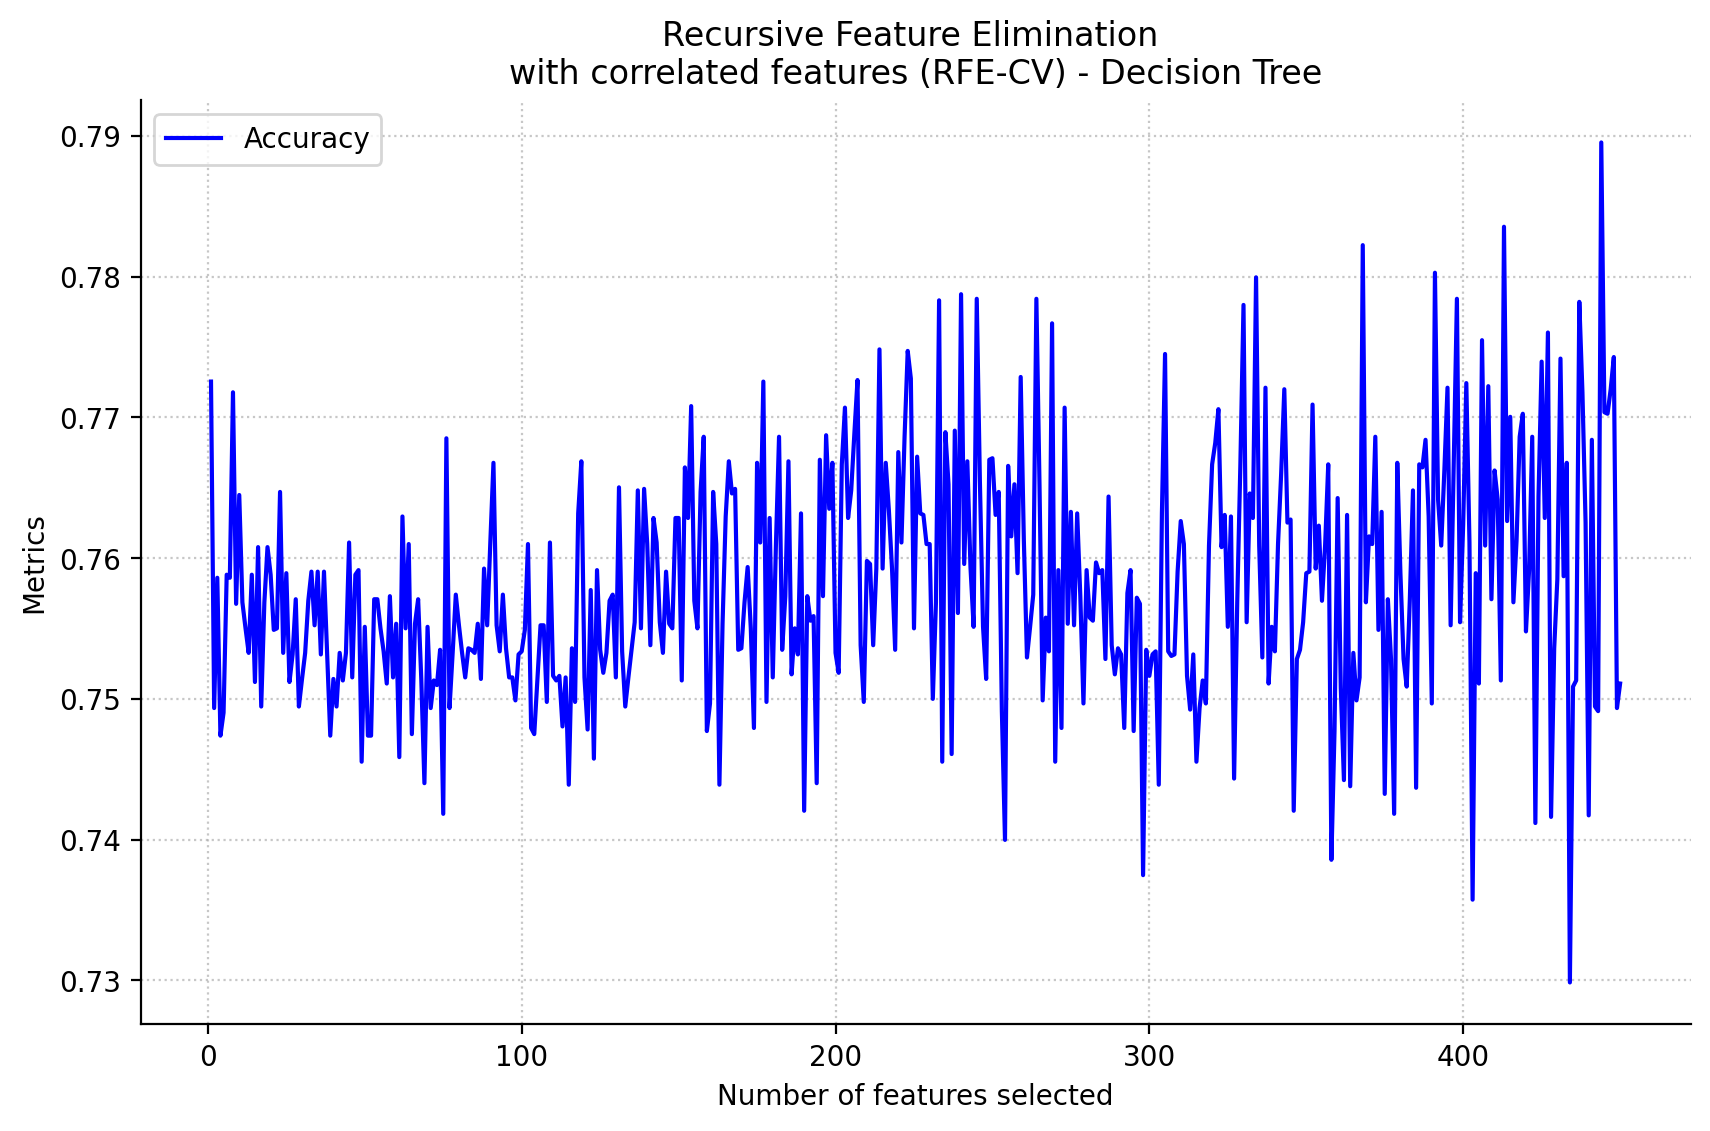

In [145]:
cv_results = pd.DataFrame(rfecv.cv_results_)

plt.figure(figsize=(10, 6))
plt.plot(cv_results['n_features'], cv_results['mean_test_score'], label="Accuracy", color='blue')

plt.title("Recursive Feature Elimination \nwith correlated features (RFE-CV) - Decision Tree")
plt.xlabel("Number of features selected")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()

In [146]:
new_model = DecisionTreeClassifier()
X_transformed = rfecv.transform(X)

scores = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='accuracy')
precision = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='precision')
recall = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='recall')
f1 = cross_val_score(new_model, X_transformed, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.7552287581699347
Precision:  0.7732070707070707
Recall:  0.7750000000000001
F1:  0.7401729027193424


# Ensemble Model - Gradient Boost


> hyperparameters are tuned focusing in preventing overfitting while maximizing recall:

- n_estimators=500 & learning_rate=0.05: Gradual learning with enough boosting rounds to extract meaningful patterns.

- max_depth=5 & gamma=3: Limits tree complexity and requires a minimum loss reduction before splitting, improving generalization.

- subsample=0.8 & colsample_bytree=0.8: Introduces randomness to reduce variance and avoid overfitting.

- reg_lambda=10 & reg_alpha=2: Strong L2 and L1 regularization to prevent excessive complexity.

- min_child_weight=1: Ensures small but meaningful splits, useful given the limited data.

- objective='binary:logistic': Outputs probabilities for better decision threshold tuning.

- eval_metric='aucpr': The Area Under the Precision-Recall Curve focuses on recall and precision.

In [147]:
bst = XGBClassifier(
    n_estimators=500,        
    max_depth=5,              
    learning_rate=0.05,       
    subsample=0.8,           
    colsample_bytree=0.8,     
    scale_pos_weight=1.4,     
    min_child_weight=1,       
    gamma=3,                  
    reg_lambda=10,            
    reg_alpha=2,              
    objective='binary:logistic', 
    eval_metric='aucpr',       
)
bst.fit(X, y)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

scores = cross_val_score(bst, X, y, cv=cv, scoring='accuracy')
precision = cross_val_score(bst, X, y, cv=cv, scoring='precision')
recall = cross_val_score(bst, X, y, cv=cv, scoring='recall')
f1 = cross_val_score(bst, X, y, cv=cv, scoring='f1')



print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.8603485838779956
Precision:  0.8390319865319866
Recall:  0.913888888888889
F1:  0.8717427555817648


> plotting the feature importance

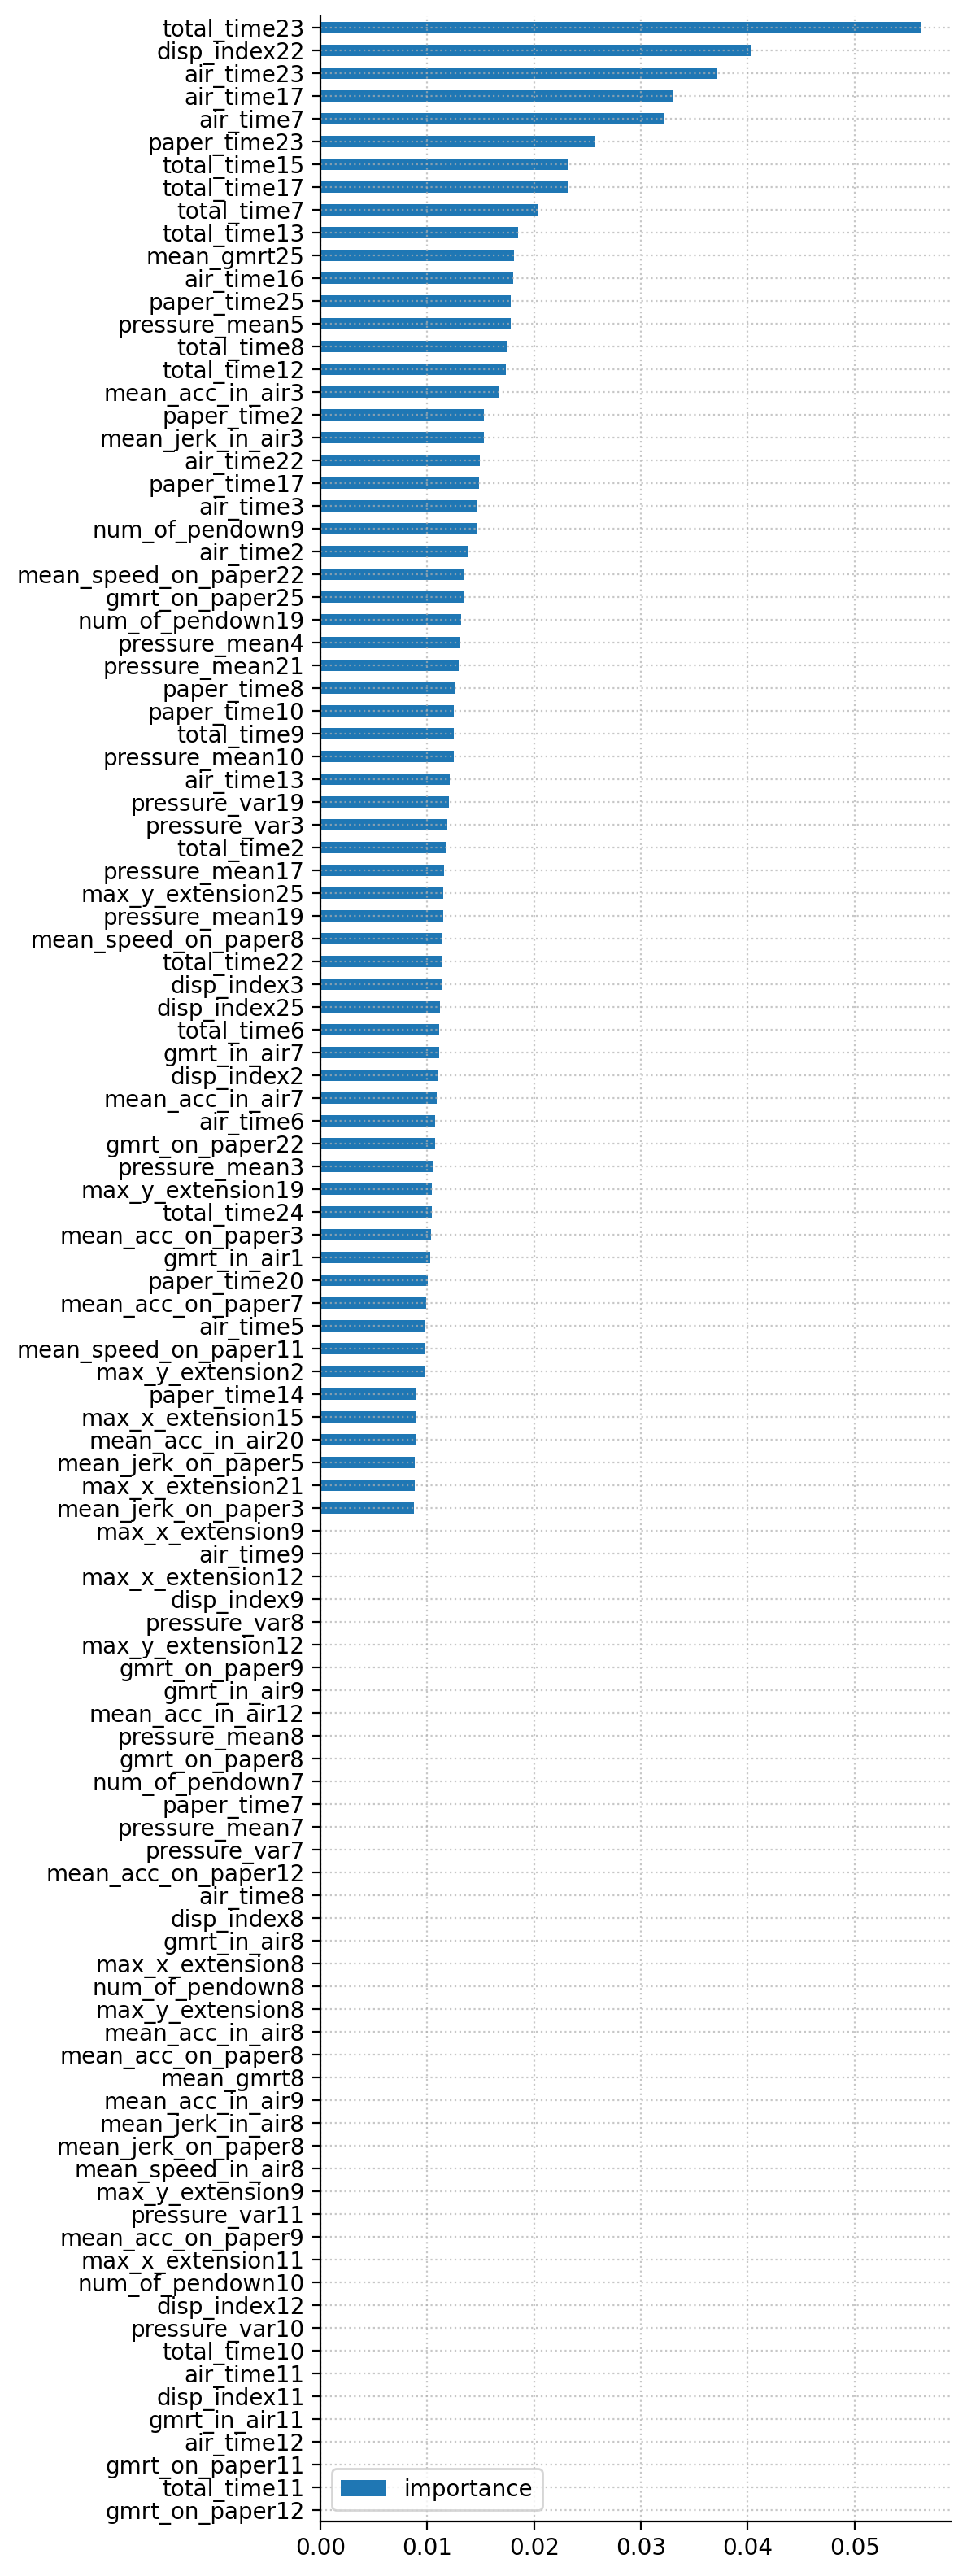

In [148]:
feature_importances = bst.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[-110:]
mlp = pd.DataFrame(feature_importances[indices], index=features[indices], columns=['importance'])
mlp.sort_values(by='importance', ascending=False)
mlp.plot(kind='barh', figsize=(5, 20))
plt.show()

## Training a Xgboost with the RFE Maximing Reccall features

In [149]:
bst_rfe = XGBClassifier(
    n_estimators=500,        
    max_depth=10,              
    learning_rate=0.05,       
    subsample=0.8,           
    colsample_bytree=0.8,     
    scale_pos_weight=2,     
    min_child_weight=1,       
    gamma=3,                  
    reg_lambda=10,            
    reg_alpha=2,              
    objective='binary:logistic', 
    eval_metric='aucpr',       
)

bst.fit(X_transformed, y)

scores = cross_val_score(bst, X_transformed, y, cv=cv, scoring='accuracy')
precision = cross_val_score(bst, X_transformed, y, cv=cv, scoring='precision')
recall = cross_val_score(bst, X_transformed, y, cv=cv, scoring='recall')
f1 = cross_val_score(bst, X_transformed, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.8507625272331156
Precision:  0.8283333333333334
Recall:  0.9064814814814814
F1:  0.8625803069765917


## Training A XGboost using a RFECV for feature selection

In [150]:
bst_rfecv = XGBClassifier(
    n_estimators=500,        
    max_depth=10,              
    learning_rate=0.05,       
    subsample=0.8,           
    colsample_bytree=0.8,     
    scale_pos_weight=2,     
    min_child_weight=1,       
    gamma=3,                  
    reg_lambda=10,            
    reg_alpha=2,              
    objective='binary:logistic', 
    eval_metric='aucpr',       
)

rfecv = RFECV(
    estimator=bst_rfecv,
    step=10,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 380


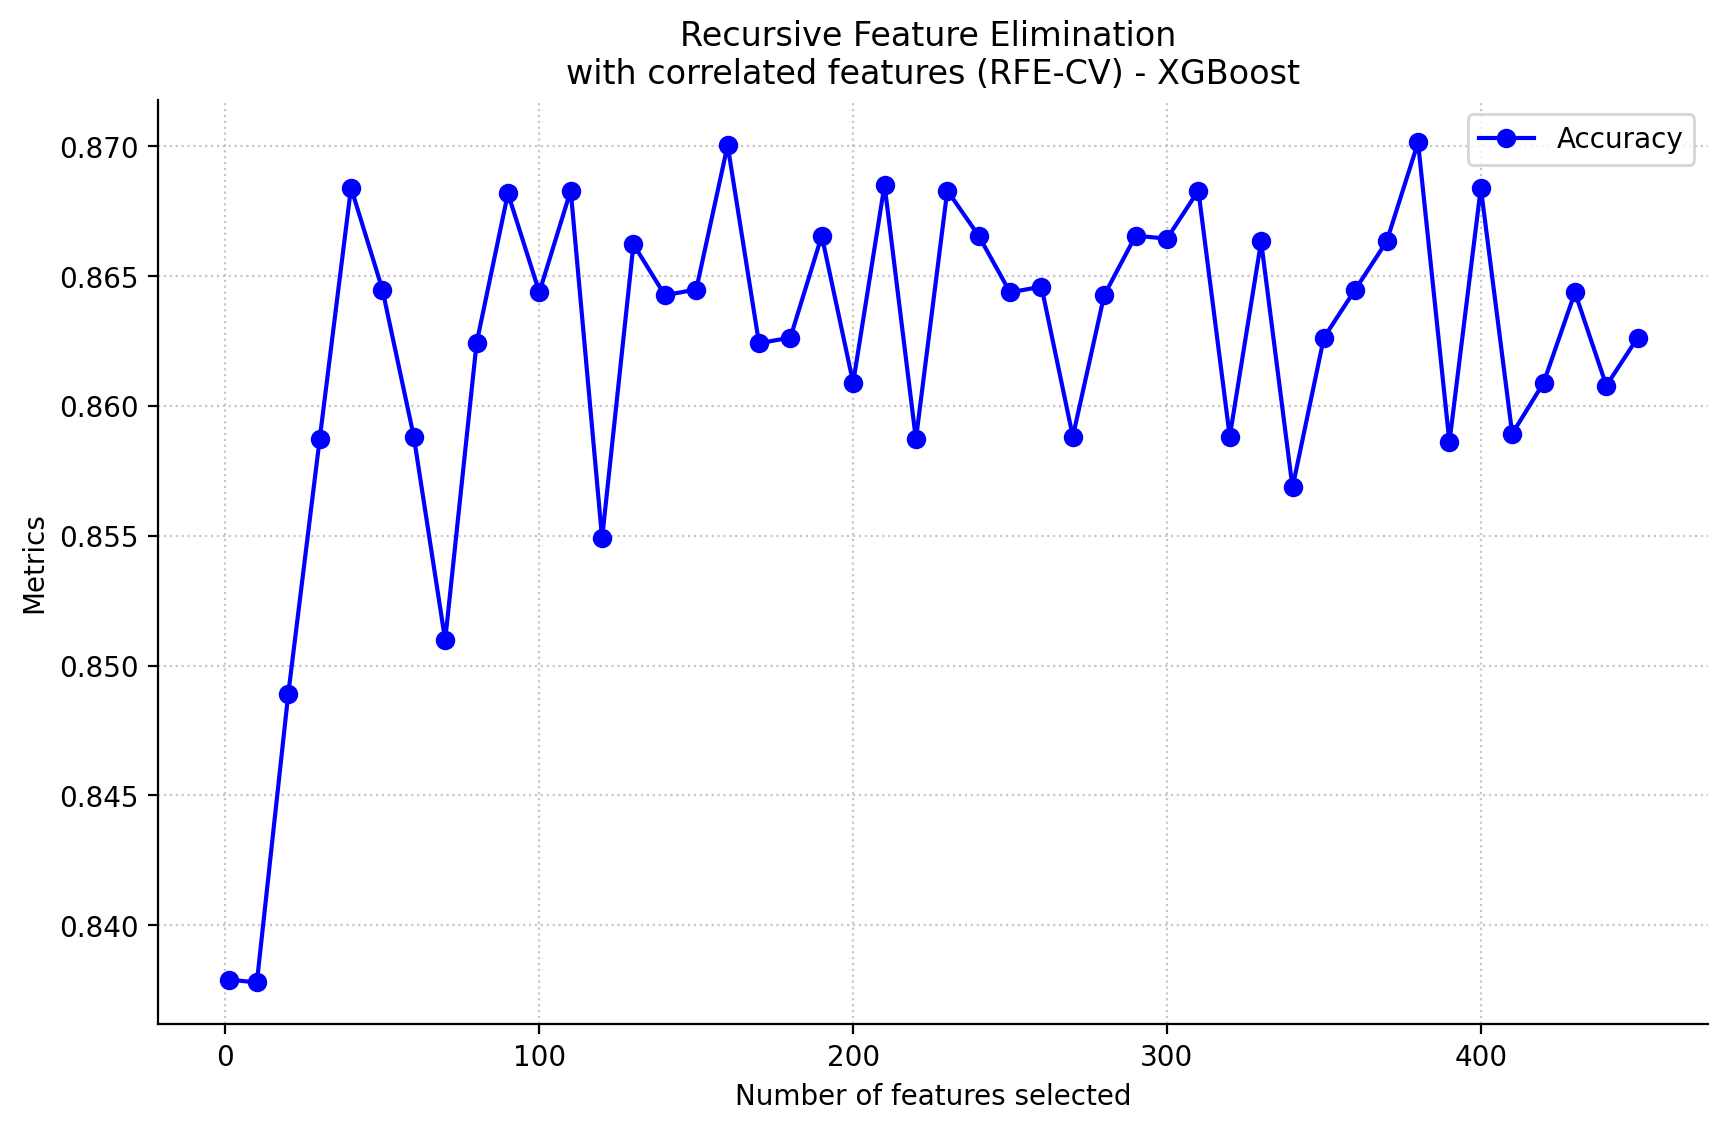

In [151]:
cv_results = pd.DataFrame(rfecv.cv_results_)

plt.figure(figsize=(10, 6))
plt.plot(cv_results['n_features'], cv_results['mean_test_score'], label="Accuracy", marker='o', color='blue')

plt.title("Recursive Feature Elimination \nwith correlated features (RFE-CV) - XGBoost")
plt.xlabel("Number of features selected")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.show()

> with the features selected I can train the final model

In [152]:
X_transformed = rfecv.transform(X)

bst_final = XGBClassifier(
    n_estimators=500,        
    max_depth=10,              
    learning_rate=0.05,       
    subsample=0.8,           
    colsample_bytree=0.8,     
    scale_pos_weight=2,     
    min_child_weight=1,       
    gamma=3,                  
    reg_lambda=10,            
    reg_alpha=2,              
    objective='binary:logistic', 
    eval_metric='aucpr',
)

scores = cross_val_score(bst_final, X_transformed, y, cv=cv, scoring='accuracy')
precision = cross_val_score(bst_final, X_transformed, y, cv=cv, scoring='precision')
recall = cross_val_score(bst_final, X_transformed, y, cv=cv, scoring='recall')
f1 = cross_val_score(bst_final, X_transformed, y, cv=cv, scoring='f1')

print('Accuracy: ', np.mean(scores))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('F1: ', np.mean(f1))

Accuracy:  0.872004357298475
Precision:  0.8332996632996632
Recall:  0.951388888888889
F1:  0.8857216570838861


# Conclusions

> During initial Decision Tree experiments using a train-test split with random state 42, I observed signs of overfitting:
> - The model consistently achieved 1.0 precision, regardless of the number of features.
> - A cross-validation test revealed a significant drop in performance compared to the initial split-based evaluation:
>     - Train-test split: Precision = 0.947, Recall = 0.900
>     - Cross-validation: Precision = 0.814, Recall = 0.776   

> This indicated that the train-test split was not representative, likely due to the small dataset (174 records). To deal with this, I decided to use only cross-validation for all further evaluations.

### Feature Selection Experiments 

#### Takeaways

> I tested two types of feature selection methods:

> - Filter Methods (Statistical-based):
>    - ANOVA-based feature selection improved recall but was not optimal.
>    - The best result was recall = 0.806.

> - Wrapper Methods (Model-based):
>    - Sequential Feature Selection (SFS) improved recall but was outperformed by Recursive Feature Elimination (RFE).
>    - RFE with 11 features provided the highest recall (0.894).

> Final Model Performance      
> Using the best feature selection method, I applied it to Gradient Boosting, which resulted in the highest recall:
> - Gradient Boost (no feature selection) → Recall = 0.925
> - Gradient Boost + RFE (best features) → Recall = 0.932
> - Gradient Boost + RFECV → Recall = 0.943


> RFECV underperformed with Decision Trees:
> - The Decision Tree model with RFECV had lower recall (0.778) compared to RFE (0.894).
> - This happened likely because Decision Trees are prone to overfitting on small datasets, and removing features in a recursive manner can sometimes remove useful weak signals that the tree could have leveraged.
> - Also, Decision Trees don't naturally handle feature importance in an ensemble way, meaning that eliminating features one by one may not always yield the best feature subset.

> RFECV worked well with Gradient Boosting:   
> - Unlike a single Decision Tree, Gradient Boosting builds multiple weak learners sequentially, correcting errors from previous iterations.   
> - Because of this iterative nature, reducing the feature space via RFECV helped the model focus on the most informative features, improving generalization and recall (0.943).   
> - In ensemble methods, some features may only contribute noise when used individually, but a feature importance-based selection (like RFECV) can identify which ones actually help across multiple trees.   

#### All results

> Decision Tree (Without Feature Selection):   
- Decision tree with random state 42 and train-test split
    - Accuracy:  0.9142857142857143
    - Precision:  0.9473684210526315
    - Recall:  0.9
    - F1:  0.9230769230769231

- Decision tree with random state 42 with cross validation also with random state 42
    - Accuracy:  0.7856209150326801
    - Precision:  0.8140392015392016
    - Recall:  0.7768518518518519
    - F1:  0.7834760323382616

> Decision Tree (ANOVA):   
- Decision tree with 10 best features selected via ANOVA
    - Accuracy:  0.7635076252723313
    - Precision:  0.7763677988677989
    - Recall:  0.7699074074074075
    - F1:  0.7684310821617324

- Decision tree with the best value for k (number of features to select) maximazing recall 
    - Max Recall: 0.7986111111111112 with 201 features
    - Accuracy:  0.7985838779956428
    - Precision:  0.8325072150072151
    - Recall:  0.8064814814814815
    - F1:  0.8014708685993516

> Decision Tree (Sequential Feature Selector):    

- Decision tree with 10 best features selected via SFS
    - Accuracy:  0.8013071895424838
    - Precision:  0.8136224886224886
    - Recall:  0.8087962962962965
    - F1:  0.8049939353731923

> Decision Tree (Recursive Feature Selector): 

- Decision tree with 10 best features selected via RFE
    - Accuracy:  0.8369281045751635
    - Precision:  0.8552717652717653
    - Recall:  0.8282407407407408
    - F1:  0.8361816305469556

- Decision tree with the best number of features maximizing recall
    - Max Recall: 0.8949074074074074 with 11 features
    - Accuracy:  0.9056644880174293
    - Precision:  0.9178306878306878
    - Recall:  0.8949074074074074
    - F1:  0.9040689141153538

- Decision Tree with RFECV
    - Accuracy:  0.7884531590413945
    - Precision:  0.8016479816479817
    - Recall:  0.7782407407407408
    - F1:  0.7832622405687422

> Gradient Boost:
- Gradient Boost without feature selection
    - Accuracy:  0.8598039215686275
    - Precision:  0.8310257335257335
    - Recall:  0.925
    - F1:  0.8706513424083083

- Gradient Boost with RFE selecting the best features with the number of features that maximizes recall
    - Accuracy:  0.8694989106753813
    - Precision:  0.8393265993265993
    - Recall:  0.9324074074074075
    - F1:  0.8800065113764804

- Gradient Boost with RFECV 
    - Accuracy:  0.8618736383442267
    - Precision:  0.8227441077441077
    - Recall:  0.9439814814814814
    - F1:  0.8752146297115339
